In [3]:
import numpy as np
import scipy
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from os import path


In [4]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [5]:
import itertools
from operator import add
from quimb import *
import quimb

r=2 # local Hilbert space dim

def ham_chain(L, g=1.0, h=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
    pairs_ss = tuple(gen_pairs())
    # pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair):
        Sz = spin_operator('z', sparse=True)
        return ikron([2*Sz, 2*Sz], dims, inds=pair)

    # function to make Z field at ``site``
    def fields(site):
        Sx = spin_operator('x', sparse=True)
        Sz = spin_operator('z', sparse=True)
        return ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss),
                                map(fields, sites))
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


In [6]:
L =14
# integrable
%time H0 = ham_chain(L=L, g=1.05, h=0, cyclic=True,sparse=False)
%time ge0, es0= np.linalg.eigh(H0)

# chaotic
%time H1 = ham_chain(L=L, g=1.05, h=0.5, cyclic=True,sparse=False)
%time ge, es= np.linalg.eigh(H1)

((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 0))
CPU times: user 84.9 ms, sys: 448 ms, total: 532 ms
Wall time: 530 ms
CPU times: user 24min 9s, sys: 16.6 s, total: 24min 25s
Wall time: 2min 2s
((0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 0))
CPU times: user 1.16 s, sys: 539 ms, total: 1.7 s
Wall time: 529 ms
CPU times: user 23min 22s, sys: 15.6 s, total: 23min 37s
Wall time: 1min 58s


In [13]:
print(ge)
print(es.shape)
# print(H1.shape)

[ 0.00610493  0.00610493 -0.02337439 -0.02337439 -0.04009637 -0.04009637
 -0.04945896 -0.04945896]
(1024, 8)


In [7]:
dN=10
Na=10
Nb = L-Na
states=np.arange(2**(L-1)-dN,2**(L-1)+dN)

neg_q=np.zeros((int(Na/2)+1,len(states)))
neg_q0=np.zeros((int(Na/2)+1,len(states)))

dims_a = [r] * Na
dims = [r] * L
N = prod(dims)

t_timer=time.time()
for i_s in range(len(states)):
    print(i_s)#, end='\r')
    st_num= states[i_s]
    psi = es[:,st_num]
    psi0 = es0[:,st_num]

    for i_n in range(int(Na/2)):
        print(i_n, end='\r')
        Na1= i_n+1
        Na2= Na-i_n-1
#         neg_q[i_n+1,i_s]=negativity_subsys_approx(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
        neg_q[i_n+1,i_s]=logneg_subsys(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
        neg_q0[i_n+1,i_s]=logneg_subsys(psi0, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
    
elapsed = time.time() - t_timer
print("Finished, quimb elapsed time = %.2f " % (elapsed)+ "sec")

# f1= 'LN_r_%d_NA_%d_NB_%d.npz' % (r,Lab,Lc)
# out_dir = 'LN_figs/' 
# fname = out_dir+f1
# np.savez(fname, logneg=neg_q)
# print(neg_q)

R12_list=np.linspace(0.0,0.499,101)
logneg=np.zeros(len(R12_list))
for i_1 in range(len(R12_list)-1):
    R12=R12_list[i_1+1]
    Lb= r**Nb
    L1= r**(R12*Na)
    L2= r**((1-R12)*Na)

    a = Lb/L2 +1j*0
    b = Lb/L2*L1 +1j*0
    logneg[i_1+1]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Finished, quimb elapsed time = 24.11 sec


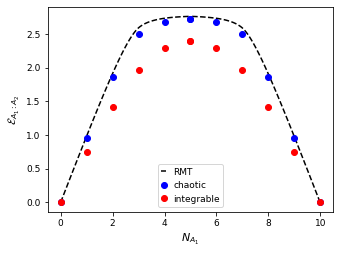

In [13]:
# f1= 'LN_r_%d_NA_%d_NB_%d.npz' % (r,Lab,Lc)
# fname = out_dir+f1
# if path.exists(fname):
#     npzfile = np.load(fname)
#     neg_q=npzfile['logneg']
#     print('Averaged over %d reps' % (np.size(neg_q,1)))


plt.figure(figsize=(4.8,3.6))
fsize=9
plt.rcParams.update({'font.size': fsize})

plt.plot(R12_list*Na,logneg,'k--')
plt.plot((0.5+R12_list[::-1])*Na,logneg,'k--',label='RMT')

# logneg_q_avg=np.log2(2*np.mean(neg_q,axis=1)+1)
logneg_q_avg= np.mean(neg_q,axis=1)
logneg_q0_avg= np.mean(neg_q0,axis=1)

plt.plot(np.arange(0,int(Na)/2+1), logneg_q_avg, 'bo',label='chaotic')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q_avg[::-1], 'bo')

plt.plot(np.arange(0,int(Na)/2+1), logneg_q0_avg, 'ro',label='integrable')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q0_avg[::-1], 'ro')

# yplot= np.array([0, 0.8482, 1.2754, 1.5003, 1.5529, 1.5628, 1.5530, 1.5002, 1.2753, 0.8481, 0.0000])/np.log(2)
yplot=[0, 0.9632, 1.8613, 2.5124, 2.6872, 2.7209, 2.6874, 2.5123, 1.8609, 0.9631, 0.0000]
# plt.plot(np.arange(0,11), yplot, 'rx',label='J')

# plt.title('$N_A$=%d' % (Na))
plt.xlabel(r'$N_{A_1}$',fontsize = fsize+2)
plt.ylabel(r'${\cal E}_{A_1:A_2}$',fontsize = fsize+2)

# plt.ylim(0,5.)
# plt.xlim(0,int(Lab)/2+1)
plt.legend(fontsize=fsize,handlelength=0.5,loc='lower center')
plt.tight_layout()
plt.savefig('figs/spin_chain_Na_%d_Nb_%d.pdf' % (Na,Nb))
plt.show()

In [ ]:
print(neg_q)